# NYC Stop and Frisk Analysis
Brad Johnson and Steven Dye

This project examines stop-and-frisks incidents in New York City from 2003-2018. The goal is to be able to predict the probability someone has to be arrested if they are the subject of a stop-and-frisk, and to improve the conversion percentage of stop and frisk incidences. The questions we are looking to answer are:

Is someone is stopped, can we predict the probability that they will be arrested?

What observed characteristics lead to arrests?



## Data

The data used in this analysis was collected from multiple sources: NYC Open Data, and the NYPD website.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import data_cleaner as dc
import importlib

importlib.reload(dc)
df = dc.load_full_sqf()
np.random.seed(5)

In [24]:
filespecs = dc.load_filespecs()
pd.options.display.max_rows=112
pd.options.display.max_colwidth=100
pd.options.display.max_columns=113
filespecs[2016][['Variable', 'Label']]

,Variable,Label
0,year,YEAR OF STOP (CCYY)
1,pct,PRECINCT OF STOP (FROM 1 TO 123)
2,ser_num,UF250 SERIAL NUMBER
3,datestop,DATE OF STOP (MM-DD-YYYY)
4,timestop,TIME OF STOP (HH:MM)
5,recstat,RECORD STATUS
6,inout,WAS STOP INSIDE OR OUTSIDE ?
7,trhsloc,WAS LOCATION HOUSING OR TRANSIT AUTHORITY ?
8,perobs,PERIOD OF OBSERVATION (MMM)
9,crimsusp,CRIME SUSPECTED


## Data Cleaning

No duplicates in the data

zeros were used to fill in missing data.

Most of the feature information was obtained during the stop-and-frisk. For this reason we separated the features into pre-stop observations and during-stop observations.

In [25]:
df_sample = df.sample(frac=.001)
df_sample.columns

Index(['year', 'pct', 'ser_num', 'recstat', 'inout', 'trhsloc', 'perobs',
       'crimsusp', 'perstop', 'typeofid',
       ...
       'ycoord', 'dettypcm', 'linecm', 'detailcm', 'datetimestop', 'wepfound',
       'forceuse', 'month', 'day', 'detail1_'],
      dtype='object', length=115)

In [26]:
# Feature Engineering
df_sample['height'] = 12*df_sample['ht_feet'] + df_sample['ht_inch']
df_sample = df_sample.drop(columns=['ht_feet', 'ht_inch'])
df_sample.columns

Index(['year', 'pct', 'ser_num', 'recstat', 'inout', 'trhsloc', 'perobs',
       'crimsusp', 'perstop', 'typeofid',
       ...
       'dettypcm', 'linecm', 'detailcm', 'datetimestop', 'wepfound',
       'forceuse', 'month', 'day', 'detail1_', 'height'],
      dtype='object', length=114)

In [27]:
# Splitting observables types
pre_stop_observables = ['year', 'pct', 'ser_num', 'inout', 'trhsloc', 'perobs', 'crimsusp', 'offunif', 'cs_objcs', 
                        'cs_descr', 'cs_casng', 'cs_lkout', 'cs_cloth', 'cs_drgtr',
                        'cs_furtv', 'cs_vcrim', 'cs_bulge', 'cs_other', 'ac_incid',
                        'ac_time', 'ac_stsnd', 'ac_other', 'repcmd', 'revcmd',
                        'sex', 'race', 'height', 'weight', 'haircolr', 'eyecolor', 
                        'build', 'othfeatr', 'addrtyp', 'rescode', 'premtype',
                        'premname', 'addrnum', 'sector', 'beat', 'post', 'xcoord', 
                        'ycoord', ]



during_stop_observables = ['recstat', 'perstop', 'typeofid', 'explnstp', 'othpers',
                         'officrid', 'frisked', 'searched', 'contrabn', 'adtlrept',
                         'pistol', 'riflshot', 'asltweap', 'knifcuti', 'machgun',
                         'othrweap', 'pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep',
                         'pf_ptwep', 'pf_baton', 'pf_hcuff', 'pf_pepsp', 'pf_other',
                         'radio', 'ac_rept', 'ac_inves', 'rf_vcrim', 'rf_othsw',
                         'ac_proxm', 'rf_attir', 'rf_vcact', 'ac_evasv', 'ac_assoc',
                         'rf_rfcmp', 'ac_cgdir', 'rf_verbl', 'rf_knowl', 'sb_hdobj',
                         'sb_outln', 'sb_admis', 'rf_furt', 'rf_bulg', 'offverb', 
                         'offshld', 'forceuse', 'dob', 'age', 'dettypCM', 
                         'detailCM']

targets = ['arstmade', 'arstoffn', 'sumissue', 'sumoffen']

In [29]:
X_observables = df_sample[pre_stop_observables]
X_observables.head()

KeyError: "['timestop', 'datestop'] not in index"

In [28]:
dc.CAT_COLS

('city',
 'sector',
 'post',
 'dettypcm',
 'officrid',
 'rescode',
 'offverb',
 'offshld',
 'forceuse',
 'sex',
 'race',
 'haircolr',
 'eyecolor',
 'build',
 'typeofid',
 'recstat',
 'inout',
 'trhsloc',
 'addrtyp',
 'month',
 'day')

In [6]:
# Drop columns that are missing a lot of data
dropped_columns = ['month', 'day', 'forceuse', 'detail1_', 'arstoffn', 'officrid',
                  'offverb', 'offshld', 'rescode', 'premtype', 'aptnum', 'state',
                  'zip', 'beat', 'post', 'crimsusp', 'stinter', 'stname', 'crossst',
                  'premname', 'sumoffen', 'othfeatr', 'addrnum', 'repcmd','dob',
                  'revcmd', 'datetimestop']
df_sample = df.sample(frac=.001)
df_sample = df_sample.drop(columns=dropped_columns)
y = df_sample.arstmade
X = df_sample.drop(columns='arstmade')
X_category = X.select_dtypes(include ='category')
categories = X_category.columns.to_list()
X_non_category = X.drop(columns=categories)

In [7]:
print(f'Total null values: {X.isna().sum().max()}')
print(y.value_counts())

Total null values: 1887
0    4796
1     290
Name: arstmade, dtype: int64


In [8]:
X_category.info()
#pd.plotting.scatter_matrix(X_category)
#plt.show();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5086 entries, 3657824 to 2812647
Data columns (total 13 columns):
recstat     4923 non-null category
inout       5047 non-null category
trhsloc     3199 non-null category
typeofid    5053 non-null category
sex         5085 non-null category
race        5085 non-null category
haircolr    5085 non-null category
eyecolor    5085 non-null category
build       5085 non-null category
addrtyp     5062 non-null category
city        4282 non-null category
sector      4160 non-null category
dettypcm    4281 non-null category
dtypes: category(13)
memory usage: 108.8 KB


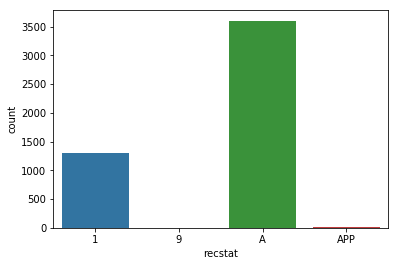

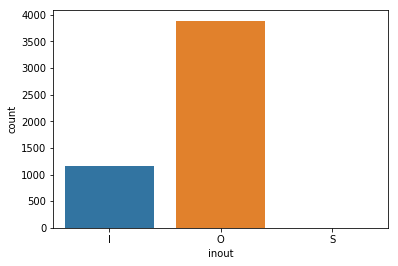

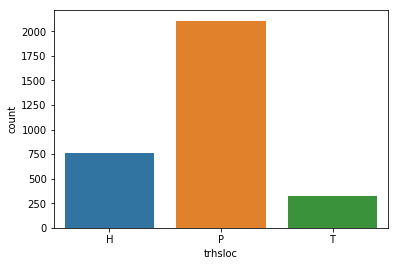

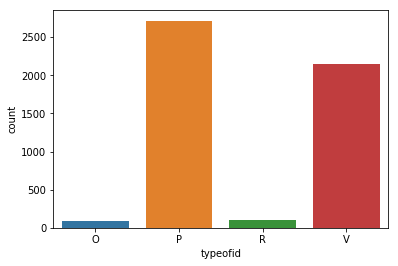

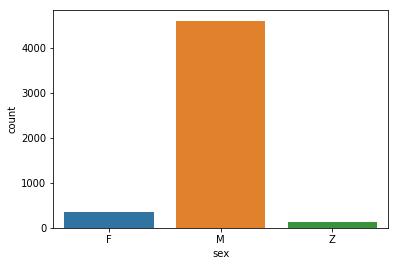

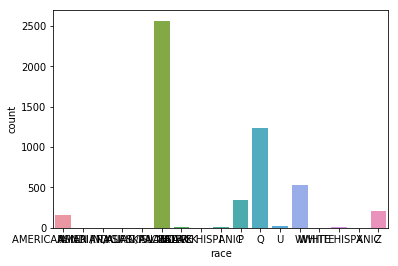

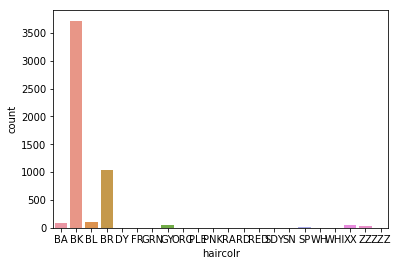

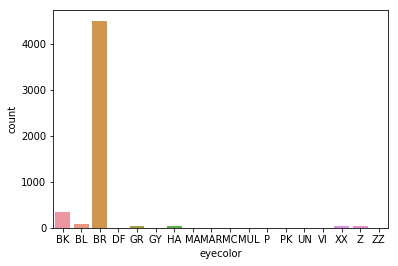

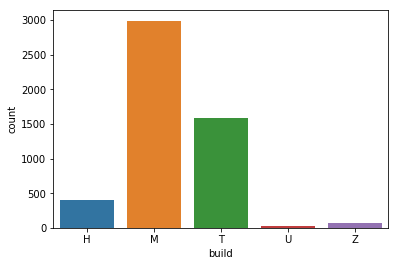

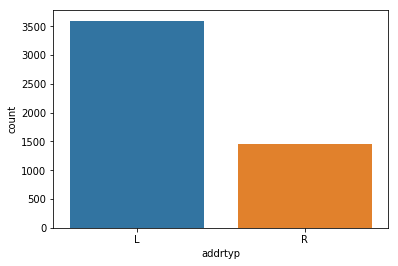

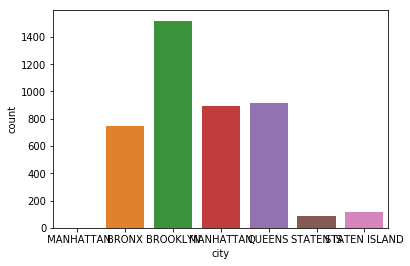

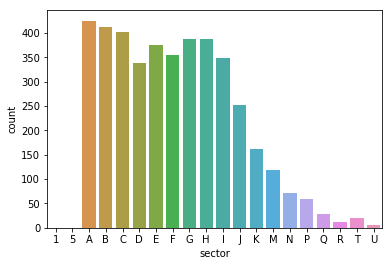

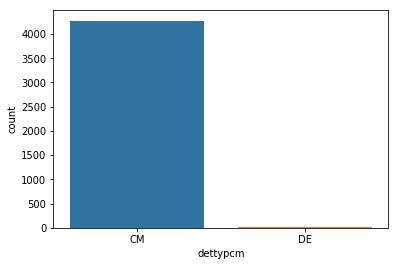

In [9]:
#df1 = df.select_dtypes([np.int, np.float])

for i, col in enumerate(X_category.columns):
    plt.figure(i)
    sns.countplot(x=col, data=X_category)

Based on selected features, can we predict the probability of someone being arrested?

In [10]:
X.isna().sum().max()

1887

In [11]:
y.value_counts()

0    4796
1     290
Name: arstmade, dtype: int64

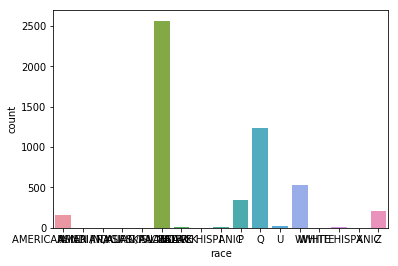

In [12]:
sns.countplot('race', data=X_category);

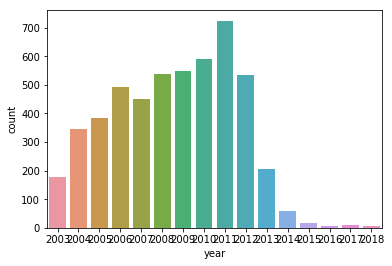

In [13]:
sns.countplot('year', data=X_non_category);

In [14]:
# Only works if there are no NaNs
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# sel.fit_transform(X_non_category)
# sel

In [15]:
X_non_category.head()

,year,pct,ser_num,perobs,perstop,explnstp,othpers,sumissue,compyear,comppct,offunif,frisked,searched,contrabn,adtlrept,pistol,riflshot,asltweap,knifcuti,machgun,othrweap,pf_hands,pf_wall,pf_grnd,pf_drwep,pf_ptwep,pf_baton,pf_hcuff,pf_pepsp,pf_other,radio,ac_rept,ac_inves,rf_vcrim,rf_othsw,ac_proxm,rf_attir,cs_objcs,cs_descr,cs_casng,cs_lkout,rf_vcact,cs_cloth,cs_drgtr,ac_evasv,ac_assoc,cs_furtv,rf_rfcmp,ac_cgdir,rf_verbl,cs_vcrim,cs_bulge,cs_other,ac_incid,ac_time,rf_knowl,ac_stsnd,ac_other,sb_hdobj,sb_outln,sb_admis,sb_other,rf_furt,rf_bulg,age,ht_feet,ht_inch,weight,addrpct,xcoord,ycoord,linecm,detailcm,wepfound
3657824,2011,44,2213.0,10.0,5.0,1,0,0,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,24.0,5,10,170.0,44,1007858.0,245023.0,1.0,85.0,0
1884111,2008,32,857.0,1.0,15.0,1,1,0,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30.0,5,10,215.0,32,1000489.0,237510.0,1.0,20.0,0
4174492,2011,14,9183.0,5.0,5.0,1,0,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,43.0,5,9,180.0,14,986061.0,213320.0,1.0,45.0,0
1497686,2007,105,1747.0,1.0,5.0,1,1,0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,22.0,5,7,160.0,105,1057879.0,203619.0,1.0,27.0,0
2073468,2008,109,3199.0,1.0,20.0,1,0,0,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,74.0,5,10,170.0,109,1031390.0,215833.0,1.0,20.0,0


In [16]:
X_non_category.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5086 entries, 3657824 to 2812647
Data columns (total 74 columns):
year        5086 non-null Int64
pct         5086 non-null Int64
ser_num     5086 non-null float64
perobs      5072 non-null float64
perstop     5085 non-null float64
explnstp    5086 non-null int8
othpers     5086 non-null int8
sumissue    5086 non-null int8
compyear    5071 non-null float64
comppct     5071 non-null float64
offunif     5086 non-null int8
frisked     5086 non-null int8
searched    5086 non-null int8
contrabn    5086 non-null int8
adtlrept    5086 non-null int8
pistol      5086 non-null int8
riflshot    5086 non-null int8
asltweap    5086 non-null int8
knifcuti    5086 non-null int8
machgun     5086 non-null int8
othrweap    5086 non-null int8
pf_hands    5086 non-null int8
pf_wall     5086 non-null int8
pf_grnd     5086 non-null int8
pf_drwep    5086 non-null int8
pf_ptwep    5086 non-null int8
pf_baton    5086 non-null int8
pf_hcuff    5086 non-null int8

In [17]:
# for feature in X_non_category.columns:
#     print(X_non_category['feature'].value_counts())

### Let's try modeling the categorical data

In [18]:
df_model = df_sample[['eyecolor', 'sex', 'arstmade']]
df_model = df_model.dropna()
X_model = df_model[['eyecolor', 'sex']]
y_model = df_model['arstmade']
print(len(y_model))
X_model

encoder = preprocessing.OneHotEncoder()
X_model = encoder.fit_transform(X_model)

5085


In [19]:
"""Transform your data"""
#X_model = X_model.reshape(-1, 1)
#X_model = X_model.toarray()


"""Optional: Hot encode your categorical data"""
#encoder = preprocessing.OneHotEncoder()
#X_model = encoder.fit_transform(X_model)
"""Split your code"""

X_train, X_test, y_train, y_test = train_test_split(X_model, y_model,
                                                    stratify=y_model)
"""Pipeline"""
"""Optional: Scale your numerical training data"""
#scaler = StandardScaler()

"""Optional: Perform over or under sampling techniques here"""
#from imblearn.over_sampling import SMOTE
#smt.SMOTE()
#X_train, y_train = smt.fit_sample(X_train, y_train)
"""Declare your model"""
#clf = svm.SVC()
#clf.fit(X_train, y_train)

rf = RandomForestClassifier(max_depth=2)
rf.fit(X_train, y_train)
#rf.feature_importances_
#RandomForestClassifier(max_depth=2, random_state=0)
print(rf.feature_importances_)
#print(clf.predict([[0, 0, 0, 0]]))
"""Do a grid search"""
#parameters = {'param_1': ('option_1', 'option_2'), 'param_2':[1, 10, 100], ...}
#model_tuned = GridSearchCV(model, parameters, cv=5)
#model_tuned.fit(X_train, y_train)


"""Make predictions"""
predictions = rf.predict(X_test)
"""Check the accuracy of your model"""
print(accuracy_score(y_test, predictions))

[0.0497851  0.03818941 0.05966387 0.         0.09550233 0.00025242
 0.11837757 0.         0.         0.0668815  0.1465841  0.13952691
 0.09705676 0.18818002]
0.9426100628930818


/Users/stevedye/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [20]:
y

3657824    0
1884111    0
4174492    0
1497686    1
2073468    0
          ..
4297048    0
3697906    0
4092563    0
1302360    0
2812647    0
Name: arstmade, Length: 5086, dtype: int8